# 1. Packages & Data Reformat

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time

In [3]:
def data_cleaning(filepath):
    
    df = pd.read_excel(filepath)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].dt.strftime('%Y-%m')
    df = df.set_index("Date")
    return df

df1 = data_cleaning('regime data.xlsx')
df2 = data_cleaning('raw data.xlsx')

In [6]:
df1

,Inflation,Recession
Date,,
1973-01,3.6,0
1973-02,3.9,0
1973-03,4.6,0
1973-04,5.1,0
1973-05,5.5,0
...,...,...
2024-05,3.3,0
2024-06,3.0,0
2024-07,2.9,0


In [184]:
df2

,MSCI World,Rex 10 Years Index,3m Bund,GSCI Commodity Index,Gold
Date,,,,,
1973-01,1.000000,1.000000,1.000000,1.000000,1.000000
1973-02,0.906052,1.014827,1.006341,0.938262,1.071833
1973-03,0.906089,1.012018,1.012722,0.914101,1.183839
1973-04,0.862074,1.004591,1.020122,0.970418,1.184575
1973-05,0.818022,0.962472,1.029418,1.091254,1.565091
...,...,...,...,...,...
2024-05,62.760653,17.458326,7.010277,10.184194,19.322397
2024-06,64.884862,17.848162,7.030652,10.462775,19.535134
2024-07,65.413311,18.065121,7.050087,9.997930,20.144126


#  2. Economics Regimes  1973-2024

C:\Users\Keqing Yan\AppData\Local\Temp\ipykernel_46312\2831039209.py:31: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


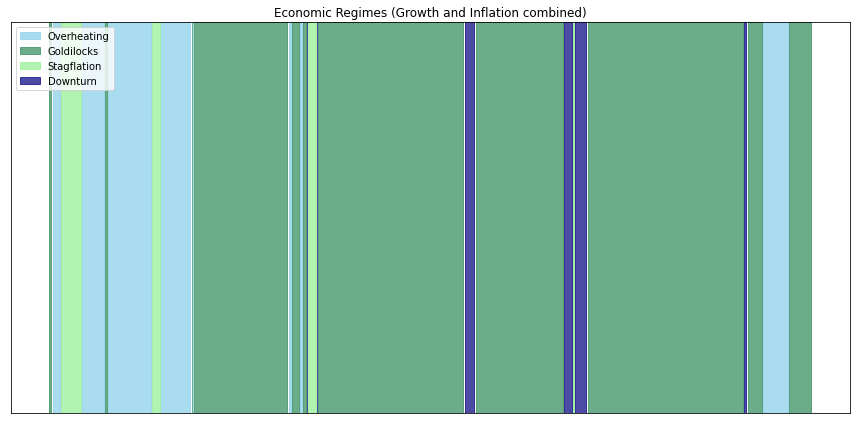

In [89]:
overheating = df1[(df1['Inflation'] > 5) & (df1['Recession'] == 0)]
goldilocks = df1[(df1['Inflation'] <= 5) & (df1['Recession'] == 0)]
stagflation = df1[(df1['Inflation'] > 5) & (df1['Recession'] == 1)]
downturn = df1[(df1['Inflation'] <= 5) & (df1['Recession'] == 1)]
df1['Regime'] = 'Unknown'
df1.loc[overheating.index, 'Regime'] = 'Overheating'
df1.loc[goldilocks.index, 'Regime'] = 'Goldilocks'
df1.loc[stagflation.index, 'Regime'] = 'Stagflation'
df1.loc[downturn.index, 'Regime'] = 'Downturn'

colors = {
    'Overheating': 'skyblue',
    'Goldilocks': 'seagreen',
    'Stagflation': 'lightgreen',
    'Downturn': 'navy'
}

plt.figure(figsize=(12, 6))
for regime, color in colors.items():
    plt.fill_between(
        df1.index,
        0, 1,
        where=(df1['Regime'] == regime),
        color=color,
        label=regime,
        alpha=0.7
    )

plt.ylim(0, 1)
plt.yticks([])
plt.xticks([])
plt.title("Economic Regimes (Growth and Inflation combined)")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# 3. Assets Performance

In [90]:
asset_returns = df2.pct_change()
asset_returns = asset_returns.dropna(axis = 0)
name_mapping = {'MSCI World': 'Equity', 
                'Rex 10 Years Index':'Bond',
               '3m Bund':'Treasury', 
               'GSCI Commodity Index':'Commodity',
               'Gold':'Gold'}
asset_returns = asset_returns.rename(name_mapping, axis = 1)
asset_returns = asset_returns[['Equity', 'Bond', 'Treasury', 'Commodity', 'Gold']]
asset_returns

,Equity,Bond,Treasury,Commodity,Gold
Date,,,,,
1973-02,-0.093948,0.014827,0.006341,-0.061738,0.071833
1973-03,0.000041,-0.002768,0.006341,-0.025750,0.104499
1973-04,-0.048577,-0.007338,0.007307,0.061609,0.000622
1973-05,-0.051100,-0.041927,0.009112,0.124519,0.321226
1973-06,-0.094282,-0.005371,0.009961,-0.115801,-0.129135
...,...,...,...,...,...
2024-05,0.029550,-0.008433,0.002991,-0.033819,-0.000440
2024-06,0.033846,0.022330,0.002906,0.027354,0.011010
2024-07,0.008144,0.012156,0.002764,-0.044428,0.031174


<AxesSubplot:title={'center':'Cumulative Return'}, xlabel='Date'>

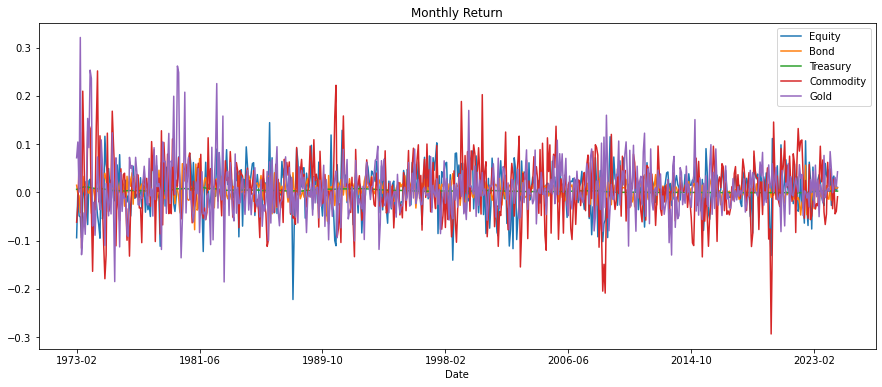

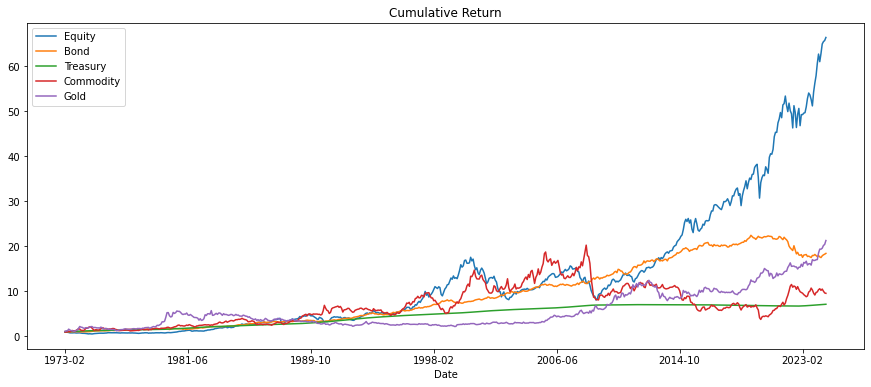

In [91]:
asset_cum_returns = (1 + asset_returns).cumprod()
# plot the returns
asset_returns.plot(figsize = (15, 6), title = 'Monthly Return')
asset_cum_returns.plot(figsize = (15, 6), title = 'Cumulative Return')

In [92]:
asset_perf = pd.DataFrame(dtype = float, columns = ['return','vol','Sharpe','Max Drawdown'])
# calculate performance
asset_perf['return'] = asset_cum_returns.iloc[-1] ** (1/(asset_cum_returns.shape[0]/52)) - 1
asset_perf['vol'] = asset_returns.std() * np.sqrt(52)
asset_perf['Sharpe'] = asset_perf['return']/asset_perf['vol']
asset_perf['Max Drawdown'] = (1 - asset_cum_returns/asset_cum_returns.cummax()).max()
asset_perf

,return,vol,Sharpe,Max Drawdown
Equity,0.421648,0.319032,1.321646,0.541490
Bond,0.276589,0.129234,2.140209,0.220630
Treasury,0.178518,0.020068,8.895640,0.046540
Commodity,0.208021,0.444814,0.467657,0.816111
Gold,0.292144,0.400987,0.728562,0.621061


In [93]:
def performance_measure(asset_returns):
    # plot the returns
    asset_returns.plot(figsize = (15, 6), title = 'Monthly Return')
    asset_perf = pd.DataFrame(dtype = float, columns = ['annualized average return','vol','sharpe'])
    # calculate performance
    asset_perf['annualized average return'] = np.mean(asset_returns, axis=0) * 12
    asset_perf['vol'] = asset_returns.std() * np.sqrt(52)
    asset_perf['sharpe'] = asset_perf['annualized average return']/asset_perf['vol']
    return asset_perf

In [94]:
def performance_measure2(asset_cum_returns,asset_returns):
    asset_perf = pd.DataFrame(dtype = float, columns = ['return','vol','sharpe'])
    # calculate performance
    asset_perf['return'] = asset_cum_returns.iloc[-1] ** (1/(asset_cum_returns.shape[0]/52)) - 1
    asset_perf['vol'] = asset_returns.std() * np.sqrt(52)
    asset_perf['sharpe'] = asset_perf['return']/asset_perf['vol']
    return asset_perf

In [95]:
goldilocks = goldilocks.drop('1973-01')
df_overheating = asset_returns.loc[overheating.index]
df_goldilocks = asset_returns.loc[goldilocks.index]
df_stagflation = asset_returns.loc[stagflation.index]
df_downturn = asset_returns.loc[downturn.index]

# 4. Regimes Test

Overheating Regime

,annualized average return,vol,sharpe
Equity,0.045934,0.299481,0.153377
Bond,0.029253,0.178381,0.163994
Treasury,0.056076,0.023997,2.336763
Commodity,0.141049,0.447260,0.315363
Gold,0.100045,0.520231,0.192309


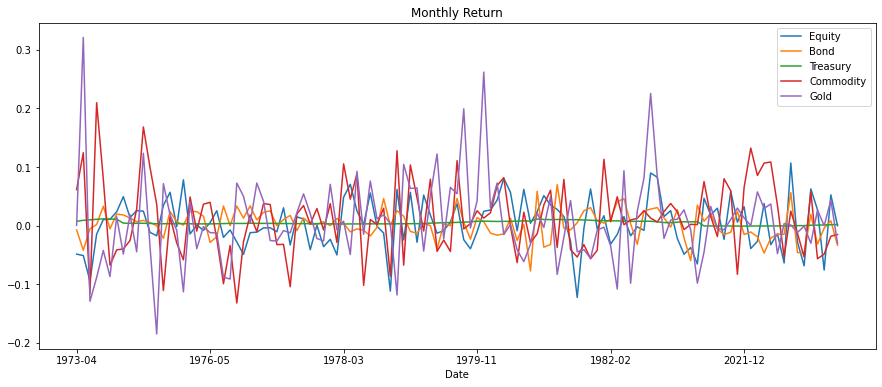

In [96]:
performance_measure(df_overheating)

Goldilocks Regime

,annualized average return,vol,sharpe
Equity,0.133753,0.294445,0.454256
Bond,0.062867,0.107640,0.584049
Treasury,0.029879,0.016358,1.826639
Commodity,0.063715,0.375276,0.169781
Gold,0.045422,0.320164,0.141871


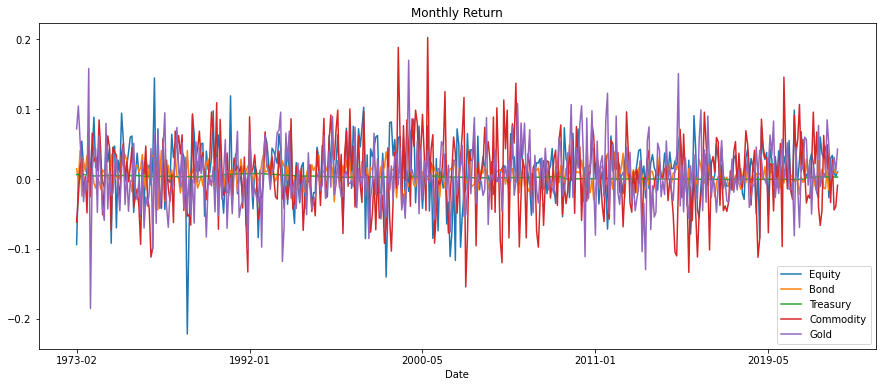

In [97]:
performance_measure(df_goldilocks)

Stagflation Regime

,annualized average return,vol,sharpe
Equity,0.000640,0.434223,0.001473
Bond,0.104739,0.182553,0.573742
Treasury,0.089791,0.011456,7.837742
Commodity,0.187590,0.790175,0.237404
Gold,0.295723,0.731298,0.404381


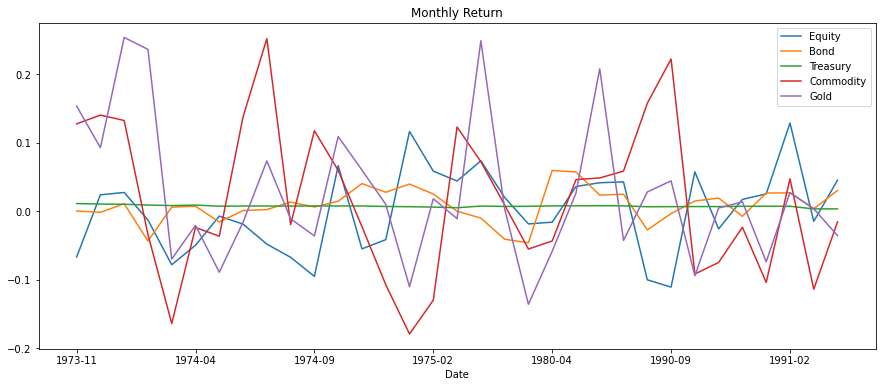

In [98]:
performance_measure(df_stagflation)

Downturn Regime

,annualized average return,vol,sharpe
Equity,-0.207237,0.487530,-0.425076
Bond,0.053751,0.126761,0.424038
Treasury,0.031569,0.013176,2.395870
Commodity,-0.297254,0.726554,-0.409128
Gold,0.212120,0.428389,0.495157


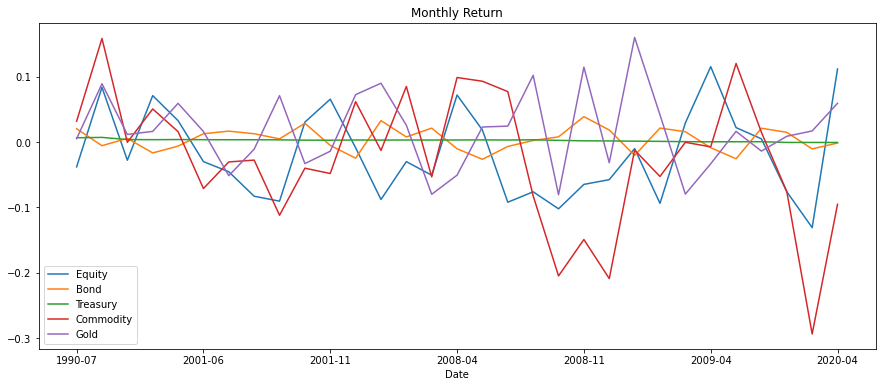

In [99]:
performance_measure(df_downturn)

# 5. Portfolio Performance

In [100]:
df1 = df1.drop(["Inflation", 'Recession'], axis=1)
df1 = df1.drop('1973-01')
df = pd.concat([asset_returns, df1], axis=1)
df

,Equity,Bond,Treasury,Commodity,Gold,Regime
Date,,,,,,
1973-02,-0.093948,0.014827,0.006341,-0.061738,0.071833,Goldilocks
1973-03,0.000041,-0.002768,0.006341,-0.025750,0.104499,Goldilocks
1973-04,-0.048577,-0.007338,0.007307,0.061609,0.000622,Overheating
1973-05,-0.051100,-0.041927,0.009112,0.124519,0.321226,Overheating
1973-06,-0.094282,-0.005371,0.009961,-0.115801,-0.129135,Overheating
...,...,...,...,...,...,...
2024-05,0.029550,-0.008433,0.002991,-0.033819,-0.000440,Goldilocks
2024-06,0.033846,0.022330,0.002906,0.027354,0.011010,Goldilocks
2024-07,0.008144,0.012156,0.002764,-0.044428,0.031174,Goldilocks


Assign weights based on benchmark +- 15%

In [156]:
weight_overheighting = np.array([0.5, 0.1, 0.1, 0.15, 0.15])
weight_goldilocks = np.array([0.7, 0.25, 0, 0.5, 0])
weight_stagflation = np.array([0.45, 0.1, 0.05, 0.2, 0.2])
weight_downturn = np.array([0.45, 0.4, 0.15, 0, 0])


In [150]:
#weight_overheighting = np.array([0.45, 0.1, 0.2, 0.17, 0.08])
#weight_goldilocks = np.array([0.45, 0.4, 0.15, 0, 0])
#weight_stagflation = np.array([0.45, 0.25, 0.00, 0.1, 0.2])
#weight_downturn = np.array([0.45, 0.35, 0, 0, 0.2])

In [157]:
def calculate_portfolio_return(row):
    if row['Regime'] == 'Overheating':
        return np.dot(row[['Equity', 'Bond', 'Treasury', 'Commodity', 'Gold']], weight_overheighting)
    elif row['Regime'] == 'Goldilocks':
        return np.dot(row[['Equity', 'Bond', 'Treasury', 'Commodity', 'Gold']], weight_goldilocks)
    elif row['Regime'] == 'Stagflation':
        return np.dot(row[['Equity', 'Bond', 'Treasury', 'Commodity', 'Gold']], weight_stagflation)
    elif row['Regime'] == 'Downturn':
        return np.dot(row[['Equity', 'Bond', 'Treasury', 'Commodity', 'Gold']], weight_downturn)
    else:
        return np.nan  
    
df['Portfolio'] = df.apply(calculate_portfolio_return, axis=1)
portfolio_return = pd.DataFrame(df['Portfolio'])
cum_returns = (1 + portfolio_return).cumprod()
#cum_returns.plot(figsize = (15, 6), title = 'Cumulative Return', color='orange')

In [158]:
benchmark = data_cleaning('benchmark_result.xlsx')
benchmark
benchmark_cum_returns = (1 + benchmark).cumprod()
# plot the returns
#benchmark_cum_returns.plot(figsize = (15, 6), title = 'Cumulative Return')

<AxesSubplot:title={'center':'Cumulative Return'}, xlabel='Date'>

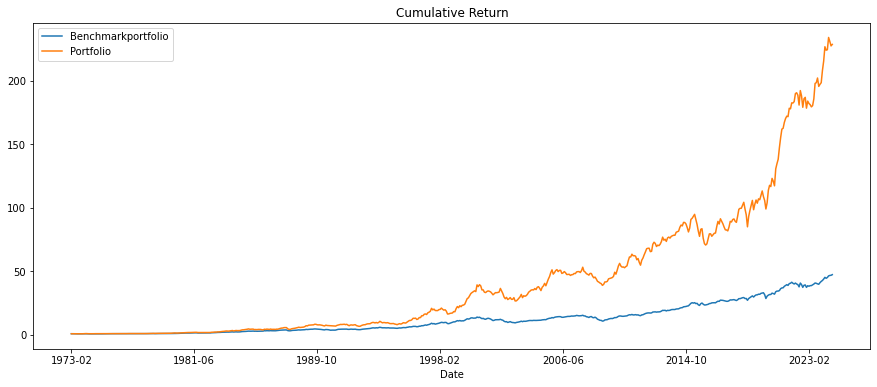

In [159]:
compare = pd.concat([benchmark_cum_returns,cum_returns], axis=1 )
compare.plot(figsize = (15, 6), title = 'Cumulative Return')

In [160]:
performance_measure2(benchmark_cum_returns,benchmark)

,return,vol,sharpe
Benchmarkportfolio,0.382131,0.203324,1.879423


In [161]:
performance_measure2(cum_returns,portfolio_return)

,return,vol,sharpe
Portfolio,0.577085,0.295305,1.9542


# 5. MVO based regime weights

In [146]:
expected_return = df_goldilocks.mean()
expected_return

Equity       0.011146
Bond         0.005239
Treasury     0.002490
Commodity    0.005310
Gold         0.003785
dtype: float64

In [147]:
cov_matrix = df_goldilocks.cov()
cov_matrix

,Equity,Bond,Treasury,Commodity,Gold
Equity,0.001667,-0.000055,-0.000004,0.000684,0.000292
Bond,-0.000055,0.000223,0.000004,-0.000106,0.000072
Treasury,-0.000004,0.000004,0.000005,-0.000001,-0.000006
Commodity,0.000684,-0.000106,-0.000001,0.002708,0.000502
Gold,0.000292,0.000072,-0.000006,0.000502,0.001971


In [176]:

def MVO(weights):
    portfolio_return = weights.T @ expected_return.values
    portfolio_std_dev = (weights.T @ cov_matrix.values @ weights) ** 0.5
    sharpe_ratio = (portfolio_return)/ portfolio_std_dev
    return -sharpe_ratio  

# Constraints: Weights sum to 1
constraints = [
    {"type": "eq", "fun": lambda weights: sum(weights) - 1}
]

bounds = [(0.45, 0.75),  
          (0.1, 0.4),    
          (0, 0.2),
         (0,0.2),
         (0,0.2)]     

init_guess = [0.6, 0.25, 0.05, 0.05, 0.05]

result = minimize(
    MVO,
    init_guess,
    bounds=bounds,
    constraints=constraints
)

optimal_weights = pd.Series(result.x, index=df_overheating.columns)
print("Optimal Weights for Max Sharpe Ratio:\n", optimal_weights)


Optimal Weights for Max Sharpe Ratio:
 Equity       0.45
Bond         0.40
Treasury     0.15
Commodity    0.00
Gold         0.00
dtype: float64


In [168]:
weight_overheighting2 = np.array([0.45, 0.1, 0.2, 0.17, 0.08])
weight_goldilocks2 = np.array([0.45, 0.4, 0.15, 0, 0])
weight_stagflation2 = np.array([0.45, 0.25, 0.00, 0.1, 0.2])
weight_downturn2 = np.array([0.45, 0.35, 0, 0, 0.2])

In [169]:
def calculate_portfolio_return(row):
    if row['Regime'] == 'Overheating':
        return np.dot(row[['Equity', 'Bond', 'Treasury', 'Commodity', 'Gold']], weight_overheighting2)
    elif row['Regime'] == 'Goldilocks':
        return np.dot(row[['Equity', 'Bond', 'Treasury', 'Commodity', 'Gold']], weight_goldilocks2)
    elif row['Regime'] == 'Stagflation':
        return np.dot(row[['Equity', 'Bond', 'Treasury', 'Commodity', 'Gold']], weight_stagflation2)
    elif row['Regime'] == 'Downturn':
        return np.dot(row[['Equity', 'Bond', 'Treasury', 'Commodity', 'Gold']], weight_downturn2)
    else:
        return np.nan  
    
df['Portfolio2'] = df.apply(calculate_portfolio_return, axis=1)
portfolio_return2 = pd.DataFrame(df['Portfolio2'])
cum_returns2 = (1 + portfolio_return2).cumprod()

<AxesSubplot:title={'center':'Cumulative Return'}, xlabel='Date'>

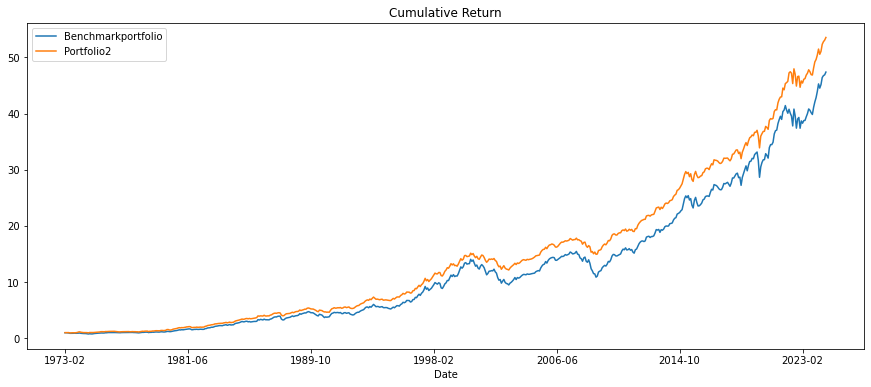

In [170]:
compare = pd.concat([benchmark_cum_returns,cum_returns2], axis=1 )
compare.plot(figsize = (15, 6), title = 'Cumulative Return')

In [174]:
performance_measure2(cum_returns2,portfolio_return2)

,return,vol,sharpe
Portfolio2,0.396388,0.159746,2.481358


# 6. Adjusted MVO based regime weights 

In [177]:
weight_heating3 = np.array([0.45, 0.1, 0.2, 0.17, 0.08])
weight_goldilocks3 = np.array([0.65, 0.2, 0.15, 0, 0])
weight_stagflation3 = np.array([0.45, 0.1, 0.00, 0.25, 0.2])
weight_downturn3 = np.array([0.45, 0.35, 0, 0, 0.2])

In [178]:
#weight_heating = np.array([0.5, 0.1, 0.1, 0.15, 0.15])
#weight_goldilocks = np.array([0.7, 0.25, 0, 0.5, 0])
#weight_stagflation = np.array([0.45, 0.1, 0.05, 0.2, 0.2])
#weight_downturn = np.array([0.45, 0.4, 0.15, 0, 0]) 

In [179]:
#weight_heating2 = np.array([0.45, 0.1, 0.2, 0.17, 0.08])
#weight_goldilocks2 = np.array([0.45, 0.4, 0.15, 0, 0])
#weight_stagflation2 = np.array([0.45, 0.25, 0.00, 0.1, 0.2])
#weight_downturn2 = np.array([0.45, 0.35, 0, 0, 0.2])

In [180]:
def calculate_portfolio_return(row):
    if row['Regime'] == 'Overheating':
        return np.dot(row[['Equity', 'Bond', 'Treasury', 'Commodity', 'Gold']], weight_heating3)
    elif row['Regime'] == 'Goldilocks':
        return np.dot(row[['Equity', 'Bond', 'Treasury', 'Commodity', 'Gold']], weight_goldilocks3)
    elif row['Regime'] == 'Stagflation':
        return np.dot(row[['Equity', 'Bond', 'Treasury', 'Commodity', 'Gold']], weight_stagflation3)
    elif row['Regime'] == 'Downturn':
        return np.dot(row[['Equity', 'Bond', 'Treasury', 'Commodity', 'Gold']], weight_downturn3)
    else:
        return np.nan  
    
df['Portfolio3'] = df.apply(calculate_portfolio_return, axis=1)
portfolio_return3 = pd.DataFrame(df['Portfolio3'])
cum_returns3 = (1 + portfolio_return3).cumprod()

<AxesSubplot:title={'center':'Cumulative Return'}, xlabel='Date'>

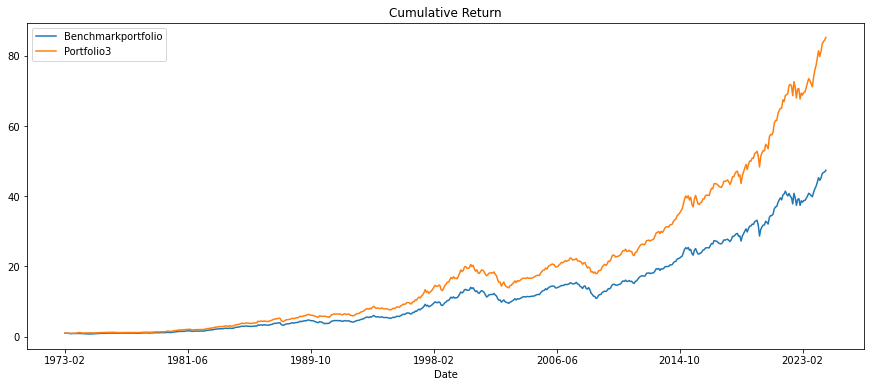

In [181]:
compare = pd.concat([benchmark_cum_returns,cum_returns3], axis=1 )
compare.plot(figsize = (15, 6), title = 'Cumulative Return')

In [182]:
performance_measure2(cum_returns3,portfolio_return3)

,return,vol,sharpe
Portfolio3,0.45187,0.200295,2.256026
